# TRABAJO PRACTICO INVOP
### Consigna 1: Licitación

#### 🏫 Generación de datos
- [X] Generar **709 escuelas** con coordenadas en un rectángulo predefinido.
- [X] Crear un conjunto de **empresas ficticias** (A, B, C, ...).
- [X] Generar **tres instancias distintas** de ofertas de las empresas para las escuelas.

#### 📊 Modelos de licitación
- [X] Implementar el **modelo básico de licitación**.
- [ ] Ejecutar el modelo para **cada una de las tres instancias**.
- [ ] Implementar y correr el **modelo alternativo** que detecta si hay **más de un óptimo**.

#### 🧩 Unidades de Competencia (UC)
- [ ] Verificar que en **alguna instancia haya más de una empresa ganadora** en una misma UC.
- [ ] Seleccionar esa UC y **aplicar el algoritmo greedy de asignación** de escuelas dentro de ella.

#### 🧪 Validación y visualización
- [X] Visualizar la **geolocalización de las escuelas** en el plano.
- [ ] Mostrar los **resultados de las licitaciones** y las **empresas ganadoras**.
- [ ] Analizar y comentar los **casos con múltiples óptimos**.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


np.random.seed(1902+209+703)

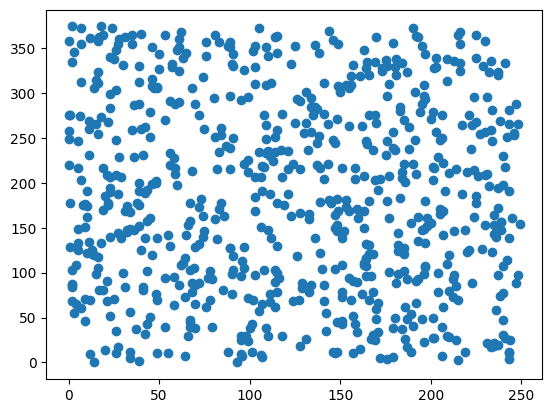

In [2]:
#Creamos el mapa y las escuelas
num_escuelas=709
diametro=250

escuelas_x = np.random.randint(0,diametro, num_escuelas)
escuelas_y = np.random.randint(0,1.5*diametro,num_escuelas)
escuelas=np.array([escuelas_x,escuelas_y]).T
plt.scatter(escuelas[:,0],escuelas[:,1])

In [3]:
#Creamos un conjunto de empresas
num_empresas=2

B1 = np.random.randint(0, 2, size=(num_escuelas, num_empresas)) 
B2 = np.random.randint(0, 2, size=(num_escuelas, num_empresas)) 
B3 = np.random.randint(0, 2, size=(num_escuelas, num_empresas)) 


In [4]:
B1.shape

(709, 2)

In [5]:
B1 #escuelas x empresas

array([[0, 1],
       [1, 0],
       [1, 1],
       ...,
       [1, 1],
       [0, 0],
       [1, 1]], dtype=int32)

In [6]:
# Subproblema 1 Construir las clases de equivalencia

def son_equivalentes(i,j,B):
    return (B[i,:]==B[j,:]).all()
        

def extraer_clases_equivalencias(B):
    clases_equivalencias=[]
    sin_ofertantes=[]
    empresas_participantes=[]
    areas_donde_participan=[[] for i in range (B.shape[1])]
    for i in range(B.shape[0]):
        lo_meti=False
        #Separamos las escuelas sin ofertantes
        if (B[i,:]==np.zeros_like(B[i,:])).all():
            sin_ofertantes.append(i)
            lo_meti=True

        j=0 #Nos fijamos en las distintas clases de equivalencias que ya definimos si i pertenece a alguna clase de equivalencia ya definida
        
        while j<len(clases_equivalencias) and not lo_meti :
            representante=clases_equivalencias[j][0]
            if son_equivalentes(i,representante,B):
                clases_equivalencias[j].append(i)
                
                lo_meti=True
            j+=1
        if not lo_meti:
            clases_equivalencias.append([i])
            
            #J_i
            aux=[]
            for ind in range(B.shape[1]):
                if B[i,ind]==1:
                    aux.append(ind)
                    #se va computando mientras se crea clases de equivalencia
                    areas_donde_participan[ind].append(len(clases_equivalencias)-1)
            empresas_participantes.append(aux)
            
    return clases_equivalencias, sin_ofertantes, empresas_participantes, areas_donde_participan

J1, sin_of, I_j ,J_i=extraer_clases_equivalencias(B1)
J2, sin_of_2, I_j_2 ,J_i_2=extraer_clases_equivalencias(B2)
J3, sin_of_3, I_j_3 ,J_i_3=extraer_clases_equivalencias(B3)

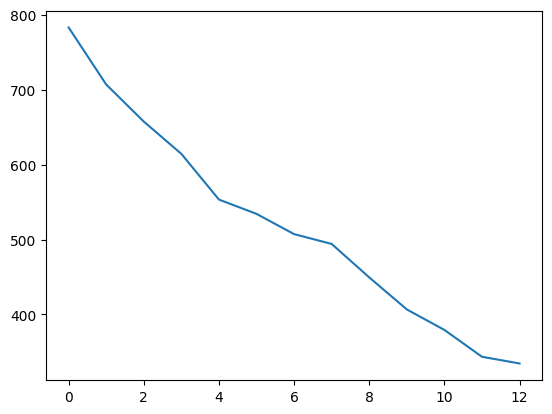

In [7]:
# Subproblema 2 Quienes son los T?
T_min=list(range(0,100,20))+list(range(100,200,50))+list(range(200,701,100))
T_max= [T_min[i]-1 for i in range(1,len(T_min))]+[709]
costos=np.zeros([num_empresas,len(T_max)])

for i in range(num_empresas):
    costos[i,0]=np.random.rand()*1000 + 400
    for t in range(1,len(T_max)):
        descuento=1-(np.random.rand()/10)
        costos[i,t]= costos[i,t-1] * descuento

costos
plt.plot(range(0,len(T_max)),costos[1])

In [8]:
from pyscipopt import Model

def definir_modelo(B,costos,nombre_modelo="Licitacion",T_max=T_max,T_min=T_min):
    model=Model(nombre_modelo)
    M=B.shape[0]
    num_empresas=B.shape[1]
    J, sin_ofertantes, I_j, J_i = extraer_clases_equivalencias(B)
    x=np.empty([num_empresas,len(J)],dtype="object")
    y=np.empty([num_empresas,len(T_max)],dtype="object")
    z=np.empty([num_empresas,len(T_max)],dtype="object")
    for i in range(num_empresas):
        for j in range(len(J)):
            #(11)
            x[i,j]=model.addVar(name=f"x_{i}_{j}",vtype="I")
            
        for t in range(len(T_max)):
            #(12)
            y[i,t]=model.addVar(name=f"y_{i}_{t}",vtype="B")
            #(13)
            z[i,t]= model.addVar(name=f"z_{i}_{t}",vtype="I")

    #(5)
    model.setObjective(sum(costos[i,t]*z[i,t] for i in range(num_empresas) for t in range(len(T_max))),"minimize")

    #(6)
    for j in range(len(J)):
        model.addCons(sum(x[i,j] for i in I_j[j]) ==len(J[j]))

    
    for i in range(num_empresas):
        #(9)
        model.addCons(sum(y[i,t] for t in range(len(T_max))) == 1)

        for t in range(len(T_max)):
            #(7)
            model.addCons(sum(x[i,j] for j in J_i[i]) >= T_min[t] - M*(1-y[i,t])) 
            #(8)
            model.addCons(sum(x[i,j] for j in J_i[i]) <= T_max[t] + M*(1-y[i,t]))
            #(10)
            model.addCons(sum(x[i,j] for j in J_i[i])-M*(1-y[i,t]) <= z[i,t])
    
    return model, sin_ofertantes,x

model, a, _= definir_modelo(B1,costos,nombre_modelo="Licitacion",T_max=T_max,T_min=T_min)


In [9]:
# model.redirectOutput()
model.optimize()
sol=model.getBestSol()
# model.writeSol(sol,"solve.xlsx")
valor_optimo=model.getObjVal()

In [10]:
# sol

In [11]:
# SIGUIENTES PASOS
# EJECUTAR PARA LAS OTRAS 2
# OBTENER SEGUNDO MEJOR OPTIMO 
# ALGORTIMO GREEDY DE DISTRIBUCION
# PLOTEARLO
# ESCRIBIR INFORME


In [12]:
def obtener_optimos_alternativos(B,costos,solucion_previa,T_max=T_max,T_min=T_min):
    model, sin_ofertantes, x = definir_modelo(B,costos,"modelo_alternativo",T_max,T_min)

    J_I_validos=[]
    a={}
    M=B.shape[0]
    for v in model.getVars():
        if v.name[0]=="x" and solucion_previa[v] != 0:
            aux=v.name.split("_") #separo los numeros [x,i,j]
            J_I_validos.append((int(aux[-1]),int(aux[1])))
            a[int(aux[-1]),int(aux[1])]=sol[v]        
    #Creamos almacenamiento de las nuevas variables
    w={}
    w_prima={}
    #añadimos las variables al modelo
    for j, i in J_I_validos:
        w[j,i]=model.addVar(name=f"w_{j}_{i}",vtype="B")
        w_prima[j,i]=model.addVar(name=f"w_prima_{j}_{i}",vtype="B")

    #añadimos las constrains para bloquear la solucion anterior
    for j,i in J_I_validos:

        model.addCons(x[i,j]>= (a[j,i]+1)*w[j,i])

        model.addCons(M - x[i,j] >= (M - (a[j,i] - 1)) * w_prima[j,i])

    model.addCons(sum(w[j,i]+w_prima[j,i] for j, i in J_I_validos)>=1)

    return model, sin_ofertantes

modelo_alternativo, sin_ofertantes_alternativo=obtener_optimos_alternativos(B1,costos,sol,T_max=T_max,T_min=T_min)


In [13]:
modelo_alternativo.optimize()
if modelo_alternativo.getObjVal() == valor_optimo:
    print(modelo_alternativo.getBestSol())
else:
    print("No hay otra solución óptima.")

No hay otra solución óptima.


In [14]:
modelo_alternativo.getObjVal() , valor_optimo

(271658.2049031903, 271415.04267582606)

In [17]:
def filtrar_variables_ganadores(modelo,solucion):
    reparto={}
    for v in model.getVars():
        if v.name[0]=="x" and solucion[v] != 0:
            aux=v.name.split("_") #separo los numeros [x,i,j]
            reparto[int(aux[1]),int(aux[-1])]=solucion[v]
    return reparto

reparto=filtrar_variables_ganadores(model,sol)
reparto

{(1, 0): 170.0, (1, 2): 195.0, (0, 1): 155.0}

In [27]:
escuelas # me gustaria agregar como una tercera columna que sea el color osea la empresa ganadora

array([[185, 121],
       [ 89, 127],
       [ 91, 119],
       ...,
       [184, 212],
       [128,  18],
       [158, 216]], dtype=int32)

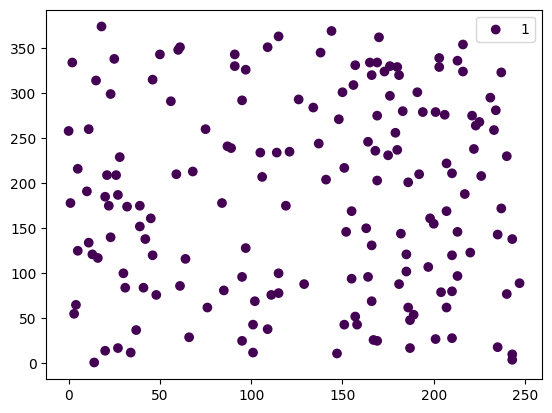

In [72]:
def plot_UC(escuelas,J,numero_unidad,reparto):
    
    #obtenemos las empresas relevantes
    keys=[]
    for i, j in reparto.keys():
        if j==numero_unidad:
            keys.append((i,j))
    
    #obtenemos las escuelas relevantes
    unidad_competencia=J[numero_unidad]
    escuelas_uc=escuelas[unidad_competencia]
    sorted_escuelas_uc=np.array(sorted(escuelas_uc,key= lambda x:(-x[1],x[0]))) #dejamos primero los puntos mas arriba a la izquierda
    c=[]
    indice=0
    for i,j in keys:
        cantidad_escuelas=int(reparto[i,j])
        c=[i+1]*cantidad_escuelas
        plt.scatter(sorted_escuelas_uc[indice:indice+cantidad_escuelas,0],sorted_escuelas_uc[indice:indice+cantidad_escuelas,1],c=c,label=f"{i}")
        indice+=cantidad_escuelas
        plt.legend()
plot_UC(escuelas,J1,0,reparto)

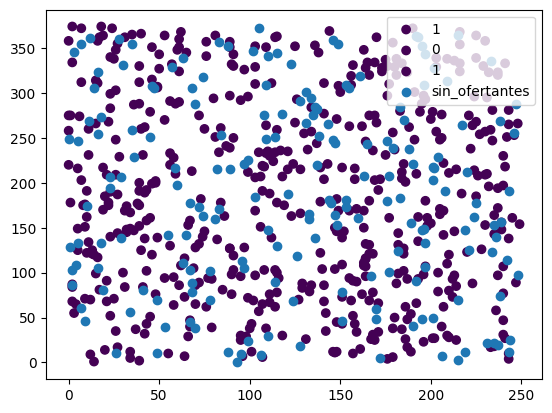

In [73]:
for unidades in range (len(J1)):
    plot_UC(escuelas,J1,unidades,reparto)

plt.scatter(escuelas[sin_of][:,0],escuelas[sin_of][:,1],label="sin_ofertantes")
plt.legend()

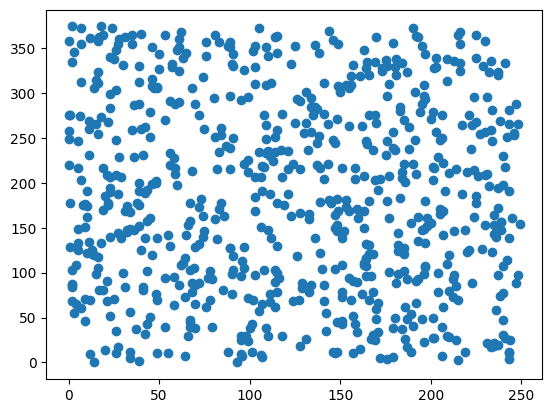

In [66]:
plt.scatter(escuelas[:,0],escuelas[:,1])